<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialisation-avec-un-an-de-données." data-toc-modified-id="Initialisation-avec-un-an-de-données.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialisation avec un an de données.</a></span></li><li><span><a href="#Fonctions" data-toc-modified-id="Fonctions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fonctions</a></span></li><li><span><a href="#Comparaison-des-modèles" data-toc-modified-id="Comparaison-des-modèles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparaison des modèles</a></span></li></ul></div>

# Simulation de fréquence 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import plotly
from plotly.offline import init_notebook_mode
import plotly.express as px
import scipy
from scipy import stats
import seaborn as sns
import sys
import sklearn
from sklearn import decomposition
from sklearn.metrics.cluster import adjusted_rand_score 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

# Versions
print('Version des librairies utilisées :')

print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Python                : ' + sys.version)
print('Plotly                : ' + plotly.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)

Version des librairies utilisées :
NumPy                 : 1.20.3
Pandas                : 1.4.1
Python                : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Plotly                : 5.6.0
Seaborn               : 0.11.2
Sklearn               : 1.0.2


In [2]:
df = pd.read_csv("data_simulation.csv")

In [3]:
df.head()

,customer_unique_id,recency,frequency,payment_value,review_score,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90,5.0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19,4.0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,536.0,1,86.22,3.0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,43.62,4.0,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,196.89,5.0,2017-11-14 19:45:42


In [4]:
df.drop("customer_unique_id", axis = 1,inplace = True)

In [5]:
print("Date du dernier achat", df.order_purchase_timestamp.max())
print("Date du premier achat", df.order_purchase_timestamp.min())

Date du dernier achat 2018-08-29 15:00:37
Date du premier achat 2016-10-03 16:56:50


In [6]:
df.order_purchase_timestamp = df.order_purchase_timestamp.apply(pd.to_datetime, format='%Y-%m-%d')

In [7]:
df.order_purchase_timestamp = df.order_purchase_timestamp.apply(lambda x: x.date())

## Initialisation avec un an de données. 

**Période T0** = 12 mois


In [8]:
df0 = df[df.order_purchase_timestamp <= (df.order_purchase_timestamp.min() + DateOffset(years=1))]

In [9]:
df0 = df0.drop("order_purchase_timestamp", axis = 1)

#standardisation
ss = StandardScaler()
df0_scaled = pd.DataFrame(data= ss.fit_transform(df0), columns = df0.columns)

#analyse en composantes principales pour réduction
pca0 = decomposition.PCA(random_state = 42)
pca0.fit(df0_scaled)
projected0 = pca0.transform(df0_scaled)

#on récupère les 3 eres composantes principales
df0_scaled["PC1"] =projected0[:,0]
df0_scaled["PC2"] = projected0[:,1]
df0_scaled["PC3"] = projected0[:,2]
    
df0_pca0 = df0_scaled[['PC1','PC2', 'PC3']]

## Fonctions

In [10]:
def calc_period(data, nbdays):
    '''
    Fonction qui crée un dataframe avec 1 an + nbdays de données
        Paramètre : 
            data : dataframe 
            nbdays : entier, nombre de jours à ajouter à 365 jours
        Sortie : Dataframe de données sur l'intervalle de temps voulu
        
    '''
    return data[data.order_purchase_timestamp <= (data.order_purchase_timestamp.min() + DateOffset(days=365+nbdays))]

In [11]:
def std_pca_data(df):
    '''
    Fonction qui standardise puis réalise une ACP et réduis à 3 composantes un Dataframe
        Paramètres : 
            df : Dataframe 
        Sortie : 
            Dataframe standardisé et projeté sur ses 3 premières composantes principales 
    '''
    df = df.drop("order_purchase_timestamp", axis = 1)
    #standardisation
    ss = StandardScaler()
    df_scaled = pd.DataFrame(data= ss.fit_transform(df), columns = df.columns)
    #analyse en composantes principales pour réduction
    pca = decomposition.PCA(random_state = 42)
    pca.fit(df_scaled)
    projected = pca.transform(df_scaled)
    #on récupère les 3 eres composantes principales
    df_projected = pd.DataFrame()
    df_projected["PC1"] =projected[:,0]
    df_projected["PC2"] = projected[:,1]
    df_projected["PC3"] = projected[:,2]
    
    #df_pca = df_scaled[['PC1','PC2', 'PC3']]
    
    return   df_projected, df_scaled   

In [12]:
def calcKmeans(df_pca): 
    '''
    Applique la segmentation K-means sur un dataframe
    
        Paramètres : 
            df_pca: dataframe (réduis avec ACP idéalement) à segmenter
        Sortie : 
            Liste des clusters calculés
    '''
    kmeans = KMeans(n_clusters = 5, random_state = 1).fit(df_pca)
    #clusters = kmeans.predict(df_pca)
    cluster_labels = kmeans.labels_
    df_pca_km = df_pca.assign(Cluster = cluster_labels)
    return  cluster_labels

## Comparaison des modèles

In [13]:
ari_score = []
for i in range(0,300,20):
    
    df_projected_i, df_scaled_i = std_pca_data(calc_period(df, i))

    #On applique la PCA initiale sur la nouvelle période
    projected_i0 = pca0.transform(df_scaled_i)
    #on récupère les 3 eres composantes principales
    df_projected_i0 = pd.DataFrame()
    df_projected_i0["PC1"] =projected_i0[:,0]
    df_projected_i0["PC2"] = projected_i0[:,1]
    df_projected_i0["PC3"] = projected_i0[:,2]
    
    #df_pca_k0 = df_scaled_k[['PC1','PC2', 'PC3']]
    ari_i = adjusted_rand_score(calcKmeans(df_projected_i0),calcKmeans(df_projected_i))
    
    ari_score.append([i,ari_i])

In [14]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"] )
ari_score

,periode,ARI
0,0,1.000000
1,20,0.968042
2,40,0.951876
3,60,0.974471
4,80,0.453088
5,100,0.465460
6,120,0.473730
7,140,0.480192
8,160,0.774463
9,180,0.855293


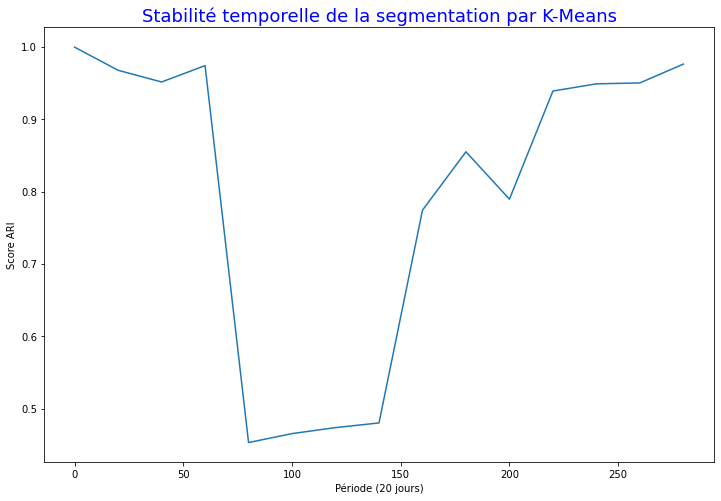

In [15]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Période (20 jours)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

On remarque une stabilité jusqu'a 60 jours suivi d'une grosse chute du score ARI. 
On peut également observer une remontée autour des 150 jours qui peut eventuellemnt s'expliquer avec le cycle des commande vu dans l'analyse exploratoire.

_________________________________________

# FIN